In [1]:
from dataclasses import dataclass, field

@dataclass
class TransformerAccountingStats:
    name: str
    vocab_size: int
    context_length: int
    num_layers: int
    d_model: int
    num_heads: int
    d_ff: int
    d_q: int = field(init=False)
    d_k: int = field(init=False)
    d_v: int = field(init=False)

    def __post_init__(self):
        self.d_q = self.d_model // self.num_heads
        self.d_k = self.d_model // self.num_heads
        self.d_v = self.d_model // self.num_heads

    def embedding_cost(self):
        count_flops = lambda m, n, p: 2 * m * n * p
        num_params = self.vocab_size * self.d_model
        num_flops = count_flops(self.context_length, self.vocab_size, self.d_model)
        return num_params, num_flops

    def mha_cost(self):
        count_flops = lambda m, n, p: 2 * m * n * p
        num_params = (
                self.d_model  # rms norm
                + self.num_heads * (
                    self.d_model * self.d_q + self.d_model * self.d_k + self.d_model * self.d_v) 
                + self.d_model * self.d_model  # MHA
        )
        num_flops = (
            count_flops(self.context_length, self.d_model, self.d_model)  # rms norm
            + self.num_heads * (
                count_flops(self.context_length, self.d_model, self.d_q)
                + count_flops(self.context_length, self.d_model, self.d_k)
                + count_flops(self.context_length, self.d_model, self.d_v)
            ) + count_flops(self.context_length, self.d_model, self.d_model) # MHA
        )
        return num_params, num_flops

    def swiglu_cost(self):
        count_flops = lambda m, n, p: 2 * m * n * p
        num_params = (
            self.d_model  # rms norm
            + 3 * self.d_ff * self.d_model  # SwigLU
        )
        num_flops = (
            count_flops(self.context_length, self.d_model, self.d_model)  # rms norm
            + 3 * count_flops(self.context_length, self.d_model, self.d_ff)  # SwigLU
        )
        return num_params, num_flops

    def ffn_cost(self):
        count_flops = lambda m, n, p: 2 * m * n * p
        num_params = (
            self.d_model  # MLP norm
            + self.d_model * self.vocab_size  # MLP
        )
        num_flops = (
            count_flops(self.context_length, self.d_model, self.d_model)  # rms norm
            + count_flops(self.context_length, self.d_model, self.vocab_size)  # MLP
        )
        return num_params, num_flops

    def num_trainable_params(self):
        return (
            self.embedding_cost()[0]
            + self.num_layers * (self.mha_cost()[0] + self.swiglu_cost()[0])
            + self.ffn_cost()[0]
        )

    def num_flops_forward(self):
        return (
            self.embedding_cost()[1]
            + self.num_layers * (self.mha_cost()[1] + self.swiglu_cost()[1])
            + self.ffn_cost()[1]
        )


In [2]:
gpt2_xl = TransformerAccountingStats(
    'gpt2_xl',
    vocab_size=50257,
    context_length=1024,
    num_layers=48,
    d_model=1600,
    num_heads=25,
    d_ff=6400,
)

In [3]:
# a) how many trainable params? => ~21 billion params; 84GiB RAM.
assert gpt2_xl.num_trainable_params() == 2127057600, gpt2_xl.num_trainable_params()

In [4]:
# b) FLOPs for a forward pass? => ~5 trillion flops
assert gpt2_xl.num_flops_forward() == 4864455475200

In [5]:
# c) SwigLU requires most FLOPs (surprisingly, not MHA).

In [11]:
# d) try other models

# GPT-2 small
gpt2_small = TransformerAccountingStats(
    'gpt2_small',
    vocab_size=50257,
    context_length=1024,
    num_layers=12,
    d_model=768,
    num_heads=12,
    d_ff=6400,
)

# GPT-2 medium
gpt2_medium = TransformerAccountingStats(
    'gpt2_medium',
    vocab_size=50257,
    context_length=1024,
    num_layers=24,
    d_model=1024,
    num_heads=16,
    d_ff=6400,
)

# GPT-2 large
gpt2_large = TransformerAccountingStats(
    'gpt2_large',
    vocab_size=50257,
    context_length=1024,
    num_layers=36,
    d_model=1280,
    num_heads=20,
    d_ff=6400,
)

import pandas as pd
models = [
    gpt2_small,
    gpt2_medium,
    gpt2_large,
    gpt2_xl,
]
df = pd.DataFrame({
    'model': [m.name for m in models],
    'num_trainable_params': [m.num_trainable_params() for m in models],
    'num_flops_forward': [m.num_flops_forward() for m in models],
    'embedding_params': [m.embedding_cost()[0] for m in models],
    'embedding_flops': [m.embedding_cost()[1] for m in models],
    'mha_params': [m.num_layers * m.mha_cost()[0] for m in models],
    'mha_flops': [m.num_layers * m.mha_cost()[1] for m in models],
    'swiglu_params': [m.num_layers * m.swiglu_cost()[0] for m in models],
    'swiglu_flops': [m.num_layers * m.swiglu_cost()[1] for m in models],
    'ffn_params': [m.ffn_cost()[0] for m in models],
    'ffn_flops': [m.ffn_cost()[1] for m in models],
})
print(df)

         model  num_trainable_params  num_flops_forward  embedding_params  \
0   gpt2_small             282472704       608663764992          38597376   
1  gpt2_medium             675499008      1488545906688          51463168   
2   gpt2_large            1249416960      2803561922560          64328960   
3      gpt2_xl            2127057600      4864455475200          80411200   

   embedding_flops  mha_params      mha_flops  swiglu_params   swiglu_flops  \
0      79047426048    28320768    72477573120      176956416   376883380224   
1     105396568064   100687872   257698037760      471883776  1017907249152   
2     131745710080   235975680   603979776000      884782080  1932735283200   
3     164682137600   491596800  1258291200000     1474636800  3271557120000   

   ffn_params     ffn_flops  
0    38598144   80255385600  
1    51464192  107544051712  
2    64330240  135101153280  
3    80412800  169925017600  


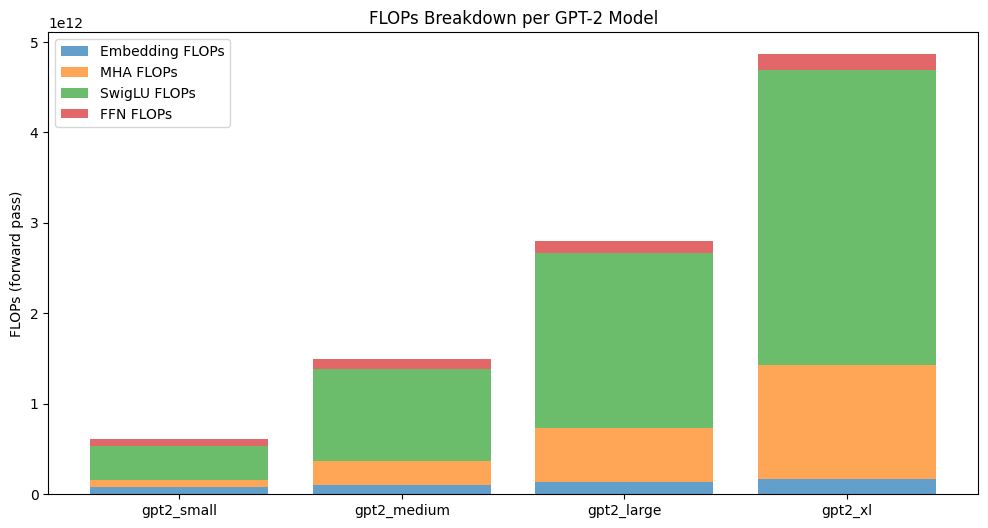

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df['model'], df['embedding_flops'], label='Embedding FLOPs', alpha=0.7)
plt.bar(df['model'], df['mha_flops'], bottom=df['embedding_flops'], label='MHA FLOPs', alpha=0.7)
plt.bar(df['model'], df['swiglu_flops'], bottom=df['embedding_flops']+df['mha_flops'], label='SwigLU FLOPs', alpha=0.7)
plt.bar(df['model'], df['ffn_flops'], bottom=df['embedding_flops']+df['mha_flops']+df['swiglu_flops'], label='FFN FLOPs', alpha=0.7)

plt.ylabel("FLOPs (forward pass)")
plt.title("FLOPs Breakdown per GPT-2 Model")
# plt.yscale('log')  # Optional: log scale for readability
plt.legend()
plt.show()


In [ ]:
# e) GPT-2 XL with large context (1024->16384) - same num params; 20x more FLOPs
gpt2_xl_large_context = TransformerAccountingStats(
    'gpt2_xl',
    vocab_size=50257,
    context_length=16384,
    num_layers=48,
    d_model=1600,
    num_heads=25,
    d_ff=6400,
)

models = [
    gpt2_xl,
    gpt2_xl_large_context,
]
df = pd.DataFrame({
    'model': [m.name for m in models],
    'num_trainable_params': [m.num_trainable_params() for m in models],
    'num_flops_forward': [m.num_flops_forward() for m in models],
    'embedding_params': [m.embedding_cost()[0] for m in models],
    'embedding_flops': [m.embedding_cost()[1] for m in models],
    'mha_params': [m.num_layers * m.mha_cost()[0] for m in models],
    'mha_flops': [m.num_layers * m.mha_cost()[1] for m in models],
    'swiglu_params': [m.num_layers * m.swiglu_cost()[0] for m in models],
    'swiglu_flops': [m.num_layers * m.swiglu_cost()[1] for m in models],
    'ffn_params': [m.ffn_cost()[0] for m in models],
    'ffn_flops': [m.ffn_cost()[1] for m in models],
})
print(df)

     model  num_trainable_params  num_flops_forward  embedding_params  \
0  gpt2_xl            2127057600      4864455475200          80411200   
1  gpt2_xl            2127057600     77831287603200          80411200   

   embedding_flops  mha_params       mha_flops  swiglu_params    swiglu_flops  \
0     164682137600   491596800   1258291200000     1474636800   3271557120000   
1    2634914201600   491596800  20132659200000     1474636800  52344913920000   

   ffn_params      ffn_flops  
0    80412800   169925017600  
1    80412800  2718800281600  
